P4 Advanced Lane Detection

In [1]:
import numpy as np
import cv2
import glob
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
import scipy.misc
import pickle


1. CAMERA CALIBRERING

In [2]:
objp = np.zeros((5*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        print('Camera calibration...')
print('Done')


Camera calibration...
Done


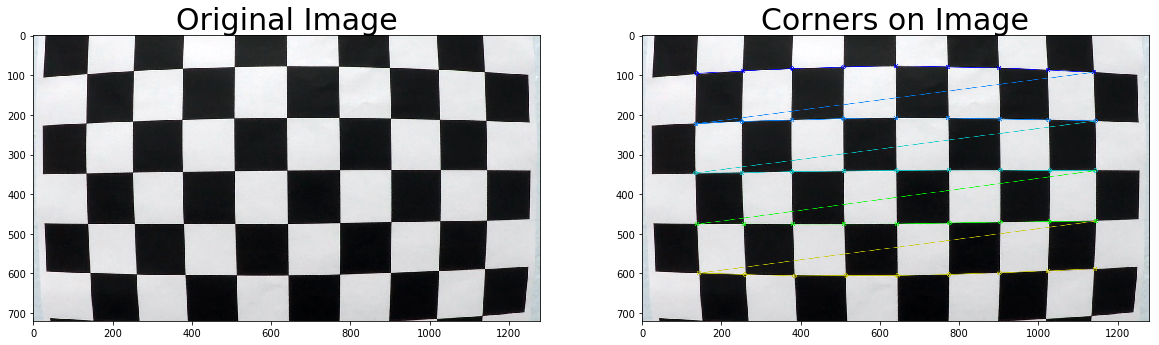

In [3]:
img_chess = cv2.imread('camera_cal/calibration1.jpg')
img_chess_org = cv2.imread('camera_cal/calibration1.jpg')
gray_chess = cv2.cvtColor(img_chess, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray_chess, (9,5), None)
cv2.drawChessboardCorners(img_chess, (9,5), corners, ret)
#plt.figure(figsize=(8,6))
#plt.imshow(img_chess)
#plt.show()
f, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_chess_org)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_chess)
ax2.set_title('Corners on Image', fontsize=30)
plt.show()

In [4]:
def undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

2.TEST ON DISTORTED IMAGE

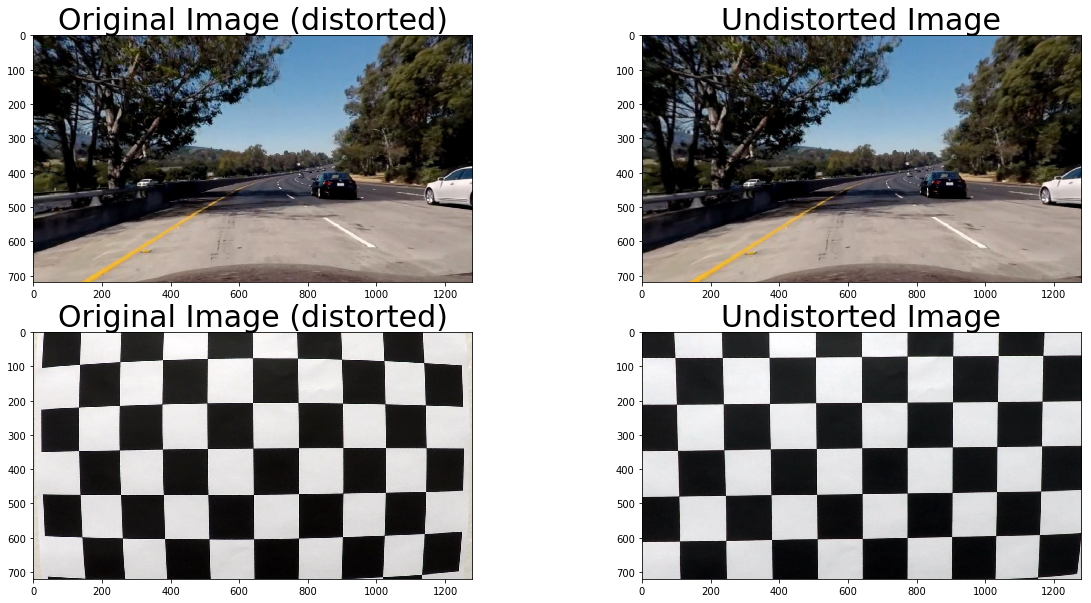

In [5]:
# Test undistortion on an image
img1 = cv2.imread('test_images/test5.jpg')
img_chess = cv2.imread('camera_cal/calibration1.jpg')

img1_size = (img1.shape[1], img1.shape[0])
img_chess_size = (img_chess.shape[1], img_chess.shape[0])
#cv2.imshow('img', img)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img1_size,None,None)


dst1 = cv2.undistort(img1, mtx, dist, None, mtx)
dst2 = cv2.undistort(img_chess, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open( "test_images/wide_dist_pickle.p", "wb" ) )
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_chess = cv2.cvtColor(img_chess, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(img1)
ax1.set_title('Original Image (distorted)', fontsize=30)
dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB)
ax2.imshow(dst1)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(img_chess)
ax3.set_title('Original Image (distorted)', fontsize=30)
ax4.imshow(dst2)
ax4.set_title('Undistorted Image', fontsize=30)


3.PERSPECTIVE TRANSFORMATION 

In [6]:
def transform_perspective(img, inverse = False):
    img_size = (img.shape[1], img.shape[0])
    #image_width = image.shape[1]
    #image_height = image.shape[0]
    
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
            
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
        
    if (inverse):
        src, dst = dst, src
        
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    #print ('src', src)
    #print ('dst', dst)
    
    return warped





4.TRANSFORMATION TEST

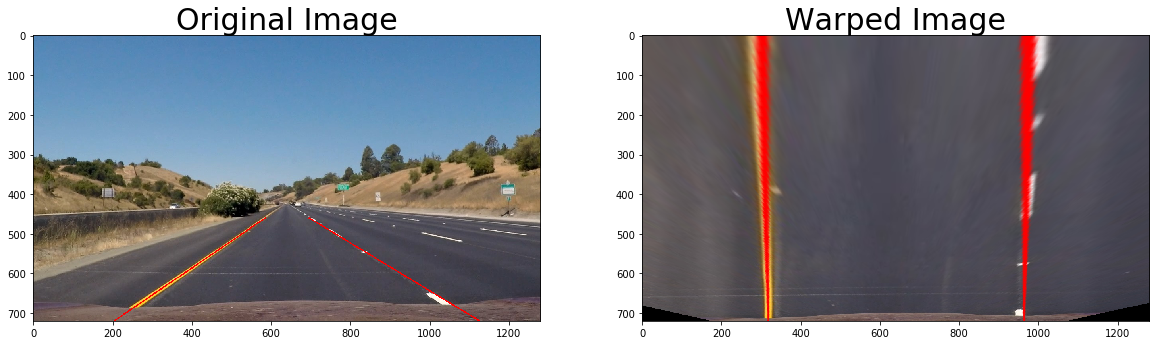

In [7]:
test_img3 = mpimg.imread('test_images/straight_lines1.jpg')


# Let's draw lines on source coordinates to visually confirm they are parallel in the destination image
cv2.line(test_img3, \
         (585, 460), \
         (203, 720), \
         (255, 0, 0), 2)
cv2.line(test_img3, \
         (1126, 720), \
         (695, 460), \
         (255, 0, 0), 2)

undistorted_image = cv2.undistort(test_img3, mtx, dist, None, mtx)
#undistorted_img = undistort(test_img3, mtx, dist)
warped = transform_perspective(undistorted_image)

# Visualize undistortion
f, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img3)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

5.THRESHOLD BINARY IMAGE

In [8]:
def thresholded_binary_image(img):
    s_thresh=(80, 255)
    b_thresh=(95, 255)
    sobel_kernel=3
    
    ############# SOBEL
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel operator calculation for x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Compute the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= s_thresh[0]) & (gradmag <= s_thresh[1])] = 1
    sxbinary=binary_output
    
    #plt.figure(figsize=(24,9))
    #plt.subplot(1, 2, 1)

    #plt.imshow(img)

    #plt.title('Original Image', fontsize=30)
    #plt.subplot(1, 2, 2)
    #plt.title('Gradient direction (Sobel)', fontsize=30)
    #plt.imshow(sxbinary, cmap='gray')
    
    
    ################################# BINARY
    # Apply color threshold
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= b_thresh[0]) & (s_channel <= b_thresh[1])] = 1
 
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1

    return combined_binary

6.TEST THRESHOLD

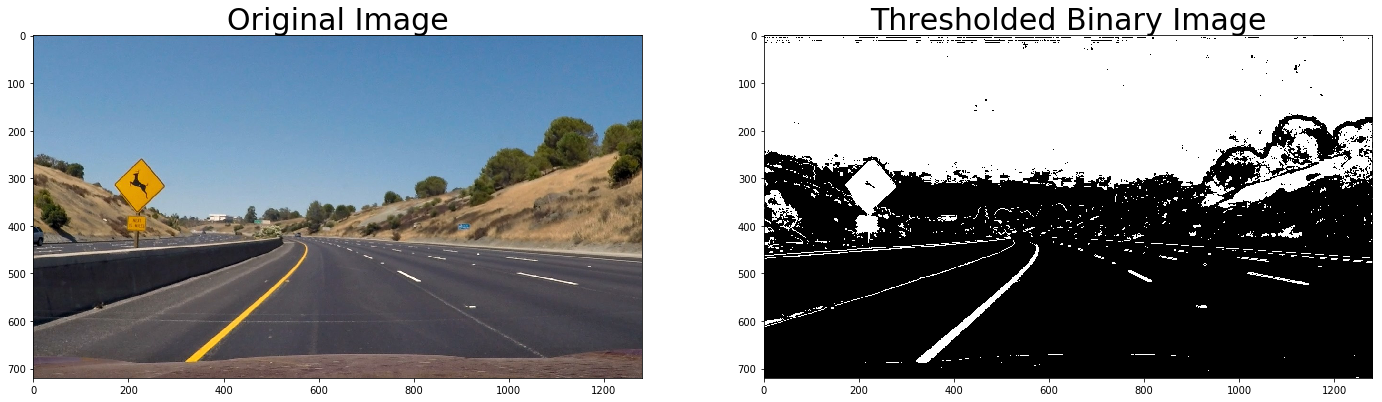

In [9]:
test_image = mpimg.imread('test_images/test2.jpg')

combined = thresholded_binary_image(test_image)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)

plt.imshow(test_image)

plt.title('Original Image', fontsize=30)
plt.subplot(1, 2, 2)
plt.title('Thresholded Binary Image', fontsize=30)
plt.imshow(combined, cmap='gray')

plt.show()

7.SLIDING WINDOW

In [10]:
def zerolistmaker(n):
    listofzeros = [[0,0,0]] * n
    return listofzeros


def find_peaks(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #####################

    # Return x-position of the two peaks
    return leftx_base, rightx_base

left_poly_prev = 0
right_poly_prev = 0
loop_first = True
buffer_length = 2
buffer_left = zerolistmaker(buffer_length)
buffer_right = zerolistmaker(buffer_length)
iteration = 0

def sliding_window(binary_warped, leftx_base, rightx_base,left_poly_prev, right_poly_prev, nwindows=9):
    
    #global  left_poly_prev
    #global right_poly_prev
    global  buffer_left
    global buffer_right
    global iteration

    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
   
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
   
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
   
    ###########################################################################    
    if (loop_first) == True:
        
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #testing
        #print('image1')
        

        
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (_poly_prev[0]*(nonzeroy**2) + left_poly_prev[1]*nonzeroy + left_poly_prev[2] - margin)) & (nonzerox < (left_poly_prev[0]*(nonzeroy**2) + left_poly_prev[1]*nonzeroy + left_poly_prev[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_poly_prev[0]*(nonzeroy**2) + right_poly_prev[1]*nonzeroy + right_poly_prev[2] - margin)) & (nonzerox < (right_poly_prev[0]*(nonzeroy**2) + right_poly_prev[1]*nonzeroy + right_poly_prev[2] + margin)))  
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
     
    return left_fit, right_fit
    

8.DETERMINE CURVATURE

In [11]:
# Calculate the lane line curvature

def measure_curvature(ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
   
    # Define y-value where we want radius of curvature
    # maximum y-value corresponds to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad
 

9.DRAW POLYGON

In [12]:
# Plot the polygons on the image
def draw_polygon(ploty, fitl, fitr, orig):
    pts_left = np.array([np.transpose(np.vstack([fitl, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitr, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    overlay = np.zeros_like(orig).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the original road
    newwarp = transform_perspective(overlay, inverse=True)
    
    # Combine the result with the original image
    result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)
    return result

In [13]:

def car_offset(left_fit, right_fit, img):

    
    xm_per_pix = 3.7/700
    hight = img.shape[0]
    width = img.shape[1]
    
    # compute position of two polynomials
    
    left_pos = left_fit[0]*hight**2+left_fit[1]*hight+left_fit[2]
    right_pos = right_fit[0]*hight**2+right_fit[1]*hight+right_fit[2]
    
    centre_pos=np.mean([left_pos,right_pos])
    # Find the offset from the centre position of two polynomials
    offset_per_pix=(width/2 - centre_pos)
    offset=offset_per_pix*xm_per_pix
    
    return abs(offset)



10.SANITY CHECKER

In [14]:
def similar_curvature(left_curverad, right_curverad):
    '''
    Checking that they are separated by approximately the right distance horizontally
    '''
    #print('sanity checker  curverad', np.abs(left_curverad-right_curverad))
    threshold =1000
    if np.abs(left_curverad-right_curverad) > threshold:
        return False
    return True

def horizontal_distance(left_fit, right_fit, img):
    '''
    Checking that they are separated by approximately the right distance horizontally
    '''
    xm_per_pix = 3.7/700
    hight = img.shape[0]
    width = img.shape[1]
    threshold_max = 4
    threshold_min = 3
    
    left_pos = left_fit[0]*hight**2+left_fit[1]*hight+left_fit[2]
    right_pos = right_fit[0]*hight**2+right_fit[1]*hight+right_fit[2]
    #print('sanity checker distance', abs(left_pos-right_pos)*xm_per_pix)
    
    if (abs(left_pos-right_pos)*xm_per_pix > threshold_max) or abs(left_pos-right_pos)*xm_per_pix < threshold_min:
        return False
    return True

def parallel(left_fit, right_fit):
    '''
    Checking that they are roughly parallel
    '''
    threshold=(0.0005, 0.5)
    for i, j, t in zip(left_fit[:2],right_fit[:2], threshold):
        if np.absolute(i - j) > t:
            return False
    return True

def sanity_checker(left_fit, right_fit, img, left_curverad, right_curverad):
    
 
    if (similar_curvature(left_curverad, right_curverad) and horizontal_distance(left_fit, right_fit, img) and parallel(left_fit, right_fit))==True:
        #print ('sanity OK')
        return True
    else:
        #print ('sanity FAIL')
        return False                                                                                                                             
                                                                                                                                        
                                                                                                                                        
    
    


11.PIPELINE

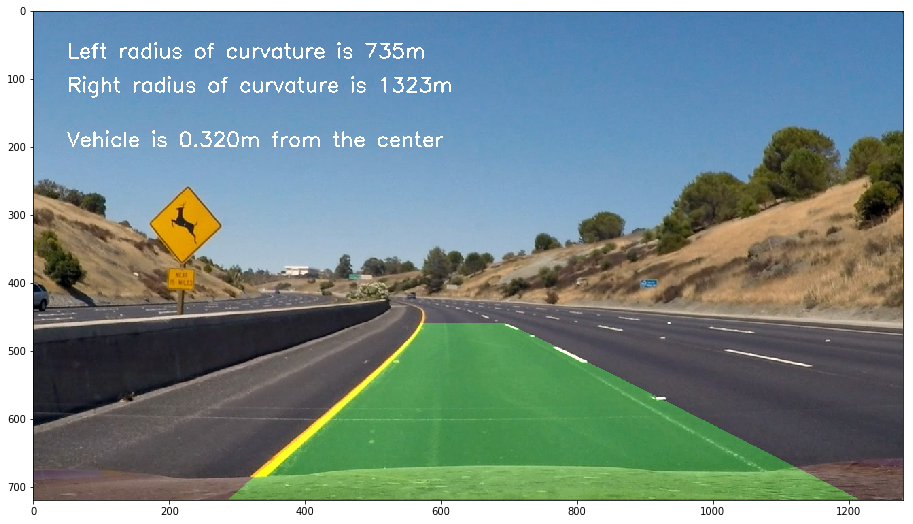

In [15]:

#left_poly_old = None
#right_poly_old = None
image_smooth = False
left_poly_buffer = None
right_poly_buffer = None
left_poly_old = None
right_poly_old = None


def pipeline(img):
    
    #definition of global variables  
    
    global left_poly_old, right_poly_old
    global  left_poly_prev, right_poly_prev
    global loop_first
    global iteration
    global  buffer_left
    global buffer_right
    global image_smooth
    global left_poly_buffer, right_poly_buffer
    

    # Undistort sample image
    undistorted_image = undistort(img, mtx, dist)
    
    # Apply combine treshold for undistorted image
    combined = thresholded_binary_image(undistorted_image)
    
    # Transform perspective
    mask = transform_perspective(combined)
    
    
    # Compute maximal values of lane peaks in image histogram
    left_peak, right_peak = find_peaks(mask)
    
    # Apply sliding windows and find cofficients of polymonials
    left_poly, right_poly = sliding_window(mask, left_peak, right_peak,left_poly_prev, right_poly_prev)
    left_poly_prev = left_poly
    right_poly_prev = right_poly
    loop_first = True
        
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
    leftx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2]
    rightx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
        
    # Compute te curvature radius
    
    left_curverad, right_curverad = measure_curvature(ploty, leftx, rightx)
    
    #testing
    #print ('curvature left',left_curverad )
    #print ('curvature right',right_curverad )
    #print('distance', left_curverad-right_curverad)
    #print ('right poly',right_poly )
    #print ('left poly',left_poly )
   
    # Get mean of curvatures
    curverad = np.mean([left_curverad, right_curverad])
  
    

        ##########Sanity Checker call#############
    if sanity_checker(left_poly, right_poly, img, left_curverad, right_curverad)==False:
        left_poly = left_poly_old
        right_poly = right_poly_old
        #print('Hallo 1')
        
        ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
        leftx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2]
        rightx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
        
        left_curverad, right_curverad = measure_curvature(ploty, leftx, rightx)
    else: 
        left_poly = left_poly
        right_poly = right_poly
        #print('Hallo 2')
        left_poly_old = left_poly
        right_poly_old = right_poly
    
    ##########BUFFER DEFINITION
    #"""
    buffer_left.append(left_poly)
    del buffer_left[0]

    buffer_right.append(right_poly)
    del buffer_right[0]
        #print('image2')
    
    iteration = iteration + 1
    
    if iteration<2:
        
        if image_smooth == False:
            left_poly = left_poly
            right_poly = right_poly
        else:
            left_poly = left_poly_buffer
            right_poly = right_poly_buffer
            
    else:
        left_poly = np.average(buffer_left, axis=0)
        right_poly = np.average(buffer_right, axis=0)
        left_poly_buffer = left_poly
        right_poly_buffer = right_poly
        iteration = 0
        image_smooth = True
        buffer_left = zerolistmaker(buffer_length)
        buffer_right = zerolistmaker(buffer_length)
    ##########END OF BUFFER
    #"""   
    
    # Draw polygon ogn processed image
    final_image = draw_polygon(ploty, leftx, rightx, img)
    offset = car_offset(left_poly, right_poly, final_image)
        
    # Write tect on processed image

    cv2.putText(final_image, 'Left radius of curvature is {}m'.format(int(left_curverad)), (50, 70), cv2.FONT_HERSHEY_SIMPLEX,  1,(255,255,255),2)
    cv2.putText(final_image, 'Right radius of curvature is {}m'.format(int(right_curverad)), (50, 120), cv2.FONT_HERSHEY_SIMPLEX,  1,(255,255,255),2)

    if offset < 0:
        text = "Vehicle is {:.3f}m left from the center".format(-offset)
    else:
        text = "Vehicle is {:.3f}m from the center".format(offset)
    cv2.putText(final_image, text, (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    xm_per_pix = 3.7/700
    hight = img.shape[0]
    width = img.shape[1]

    left_pos = left_poly[0]*hight**2+left_poly[1]*hight+left_poly[2]
    right_pos = right_poly[0]*hight**2+right_poly[1]*hight+right_poly[2]
    
    #testing
    #print(left_pos)
    #print(right_pos)
    #print('separated',abs(left_pos-right_pos)*xm_per_pix)
    
    return final_image

#perform the test on sample image
test_image = mpimg.imread('test_images/test2.jpg')

result= pipeline(test_image)

plt.figure(figsize=(24,9))
    
plt.imshow(result)

12.PROCESS LANE DETECTION ON PROJECT VIDEOS

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_input = 'project_video.mp4'
video_output = 'project_video_detected.mp4'


clip2 = VideoFileClip(video_input)
project_clip = clip2.fl_image(pipeline)
%time project_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video project_video_detected.mp4
[MoviePy] Writing video project_video_detected.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:17<00:00,  9.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detected.mp4 

Wall time: 2min 17s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_input = 'challenge_video.mp4'
video_output = 'challenge_video_detected.mp4'


clip2 = VideoFileClip(video_input)
project_clip = clip2.fl_image(pipeline)
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_detected.mp4
[MoviePy] Writing video challenge_video_detected.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:49<00:00,  9.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_detected.mp4 

Wall time: 50.3 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_input = 'harder_challenge_video.mp4'
video_output = 'harder_challenge_video_detected.mp4'


clip2 = VideoFileClip(video_input)
project_clip = clip2.fl_image(pipeline)
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_detected.mp4
[MoviePy] Writing video harder_challenge_video_detected.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [02:21<00:00,  8.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_detected.mp4 

Wall time: 2min 22s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))